# Long Short-Term Memory Neural Network

Sources referred to for codes:

Hochreiter, S., & Schmidhuber, J. (1997). Long short-term memory. Neural computation, 9(8), 1735-1780.

This paper is the original introduction to Long Short-Term Memory (LSTM) networks, describing the architecture and benefits of using LSTM for handling long-term dependencies in sequential data.
Graves, A., Mohamed, A. R., & Hinton, G. (2013). Speech recognition with deep recurrent neural networks. In 2013 IEEE International Conference on Acoustics, Speech and Signal Processing (pp. 6645-6649). IEEE.

This work demonstrates LSTM applications in deep neural networks, particularly for sequential data like speech, and provides insights into tuning LSTM for complex time series tasks.
Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). Attention is all you need. Advances in neural information processing systems, 30.

This foundational paper introduces the concept of attention mechanisms, which are now commonly incorporated into LSTM-based models to improve focus on relevant parts of sequences.
Brownlee, J. (2018). Deep Learning for Time Series Forecasting: Predict the Future with MLPs, CNNs and LSTMs in Python. Machine Learning Mastery.

Brownlee provides practical implementations of LSTM models for time series forecasting, including methods for creating input sequences and tuning LSTM parameters. Available at Machine Learning Mastery.
Chollet, F. (2015). Keras. GitHub repository. https://github.com/fchollet/keras

Keras documentation and example codes are essential resources for building LSTM models in Python. The Keras repository includes examples of LSTM architectures for various applications.
Graves, A. (2012). Supervised sequence labelling with recurrent neural networks. In Studies in Computational Intelligence, Vol. 385. Springer, Berlin, Heidelberg.

This book covers practical applications of LSTM and other recurrent neural networks, including code and explanations on sequence modeling and handling time series data.
Pytorch Team. (2019). PyTorch Documentation. https://pytorch.org/docs/stable/index.html

The official PyTorch documentation provides extensive examples and best practices for implementing LSTM models, including tutorials on sequence modeling and time series forecasting with LSTM and attention layers.

One-time prediction applied on LSTM model for MMM prediction 

C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3076911728.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])  # Log transformation of target variable
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3076911728.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()  # 7-day moving average
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3076911728.py:18: SettingWithC

Epoch 1/150 - MMM - Training Loss: 0.0292, Validation Loss: 0.0487
Epoch 2/150 - MMM - Training Loss: 0.0030, Validation Loss: 0.0178
Epoch 3/150 - MMM - Training Loss: 0.0239, Validation Loss: 0.0151
Epoch 4/150 - MMM - Training Loss: 0.1969, Validation Loss: 0.0936
Epoch 5/150 - MMM - Training Loss: 0.1328, Validation Loss: 0.0605
Epoch 6/150 - MMM - Training Loss: 0.1508, Validation Loss: 0.0709
Epoch 7/150 - MMM - Training Loss: 0.1411, Validation Loss: 0.0635
Epoch 8/150 - MMM - Training Loss: 0.1395, Validation Loss: 0.0656
Epoch 9/150 - MMM - Training Loss: 0.1451, Validation Loss: 0.0673
Epoch 10/150 - MMM - Training Loss: 0.1411, Validation Loss: 0.0649
Epoch 11/150 - MMM - Training Loss: 0.1391, Validation Loss: 0.0635
Epoch 12/150 - MMM - Training Loss: 0.1372, Validation Loss: 0.0634
Epoch 13/150 - MMM - Training Loss: 0.1374, Validation Loss: 0.0632
Early stopping triggered for MMM

MMM - One-Time Prediction Results:
Mean Squared Error (MSE): 318.6568077717322
Root Mean Sq

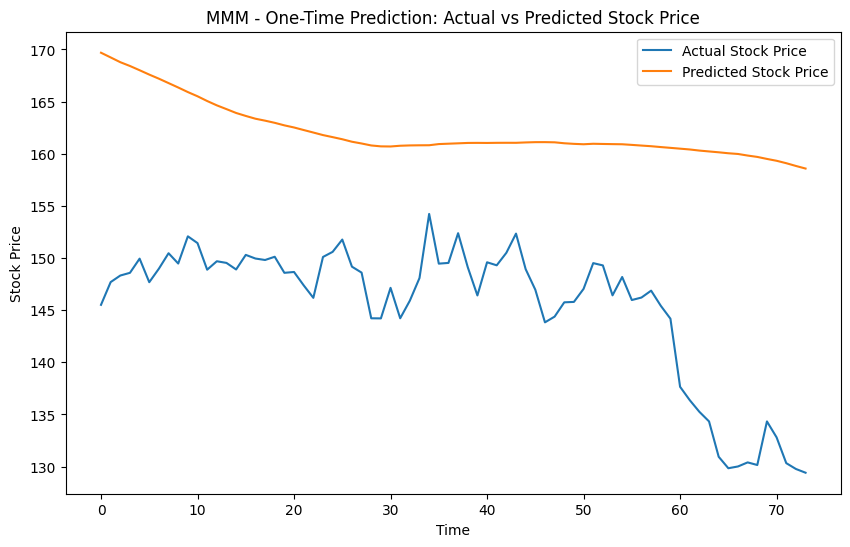

In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load and preprocess the dataset
data = pd.read_csv("C:/Users/tanxi/Downloads/company_stock_details.csv", low_memory=False)

# Filter data for "MMM" ticker only
data_filtered = data[data['Symbol'] == "MMM"]

# Feature engineering
data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])  # Log transformation of target variable
data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()  # 7-day moving average
data_filtered['Close_MA30'] = data_filtered['Close'].rolling(window=30).mean()  # 30-day moving average
data_filtered = data_filtered[['Close_Log', 'Volume', 'News - Positive Sentiment', 'News - Negative Sentiment', 
                               'News - New Products', 'News - Analyst Comments', 'News - Adverse Events', 
                               'Close_MA7', 'Close_MA30']].dropna()

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_filtered)

# Define function to create sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # Predicting the 'Close_Log' (log-transformed close price)
    return np.array(X), np.array(y)

# Hyperparameters
sequence_length = 45
hidden_layer_size = 384
num_layers = 1
dropout_rate = 0.2
learning_rate = 0.00005
batch_size = 16
epochs = 150
early_stopping_patience = 10

# Create sequences
X, y = create_sequences(scaled_data, sequence_length)

# Split into train and validation sets
split_index = int(len(X) * 0.8)
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]

# Convert to tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

# Define the Attention LSTM model
class AttentionLSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size=1, num_layers=1):
        super(AttentionLSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True, bidirectional=True)
        self.attention = nn.Linear(hidden_layer_size * 2, 1)
        self.linear = nn.Linear(hidden_layer_size * 2, output_size)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_layer_size).requires_grad_()
        c_0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_layer_size).requires_grad_()

        lstm_out, _ = self.lstm(x, (h_0, c_0))  # LSTM output
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)  # Compute attention weights
        context = torch.sum(attn_weights * lstm_out, dim=1)  # Weighted sum
        predictions = self.linear(context)
        return predictions

# Initialize the model, loss function, and optimizer
input_size = data_filtered.shape[1]
model = AttentionLSTM(input_size=input_size, hidden_layer_size=hidden_layer_size)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Early stopping setup
min_val_loss = np.inf
early_stop_counter = 0

# Training loop
for epoch in range(epochs):
    model.train()
    for i in range(0, len(X_train_tensor), batch_size):
        X_batch = X_train_tensor[i:i+batch_size]
        y_batch = y_train_tensor[i:i+batch_size]
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_function(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        X_val_tensor = torch.from_numpy(X_val).float()
        y_val_tensor = torch.from_numpy(y_val).float()
        y_pred_val = model(X_val_tensor)
        val_loss = loss_function(y_pred_val, y_val_tensor.unsqueeze(1)).item()
    
    print(f"Epoch {epoch+1}/{epochs} - MMM - Training Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}")
    
    # Scheduler step
    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stopping_patience:
            print("Early stopping triggered for MMM")
            break

# One-time prediction on the validation set
model.eval()
with torch.no_grad():
    X_val_tensor = torch.from_numpy(X_val).float()
    y_pred_val = model(X_val_tensor).squeeze().numpy()

# Rescale and evaluate
actual_values_rescaled = np.expm1(scaler.inverse_transform(
    np.concatenate([y_val.reshape(-1, 1), np.zeros((len(y_val), input_size - 1))], axis=1))[:, 0])
predicted_values_rescaled = np.expm1(scaler.inverse_transform(
    np.concatenate([y_pred_val.reshape(-1, 1), np.zeros((len(y_pred_val), input_size - 1))], axis=1))[:, 0])

# Calculate error metrics
mse = mean_squared_error(actual_values_rescaled, predicted_values_rescaled)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_values_rescaled - predicted_values_rescaled) / actual_values_rescaled)) * 100

# Print results
print(f"\nMMM - One-Time Prediction Results:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Plot the actual and predicted stock prices for "MMM"
plt.figure(figsize=(10, 6))
plt.plot(actual_values_rescaled, label='Actual Stock Price')
plt.plot(predicted_values_rescaled, label='Predicted Stock Price')
plt.title('MMM - One-Time Prediction: Actual vs Predicted Stock Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


Rolling forecast applied on LSTM model for MMM prediction

C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\1447225397.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])  # Log transformation of target variable
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\1447225397.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()  # 7-day moving average
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\1447225397.py:18: SettingWithC

Epoch 1/150, Training Loss: 0.040658120065927505, Validation Loss: 0.057664334774017334
Epoch 2/150, Training Loss: 0.01851104386150837, Validation Loss: 0.033004771918058395
Epoch 3/150, Training Loss: 0.000699445663485676, Validation Loss: 0.009731709957122803
Epoch 4/150, Training Loss: 0.06429756432771683, Validation Loss: 0.030810894444584846
Epoch 5/150, Training Loss: 0.049237363040447235, Validation Loss: 0.026280242949724197
Epoch 6/150, Training Loss: 0.056491654366254807, Validation Loss: 0.03005434386432171
Epoch 7/150, Training Loss: 0.04699953645467758, Validation Loss: 0.025979219004511833
Epoch 8/150, Training Loss: 0.05473756045103073, Validation Loss: 0.03130904585123062
Epoch 9/150, Training Loss: 0.045939646661281586, Validation Loss: 0.026650864630937576
Epoch 10/150, Training Loss: 0.0497482605278492, Validation Loss: 0.02863875962793827
Epoch 11/150, Training Loss: 0.04500021040439606, Validation Loss: 0.026113705709576607
Epoch 12/150, Training Loss: 0.046276152

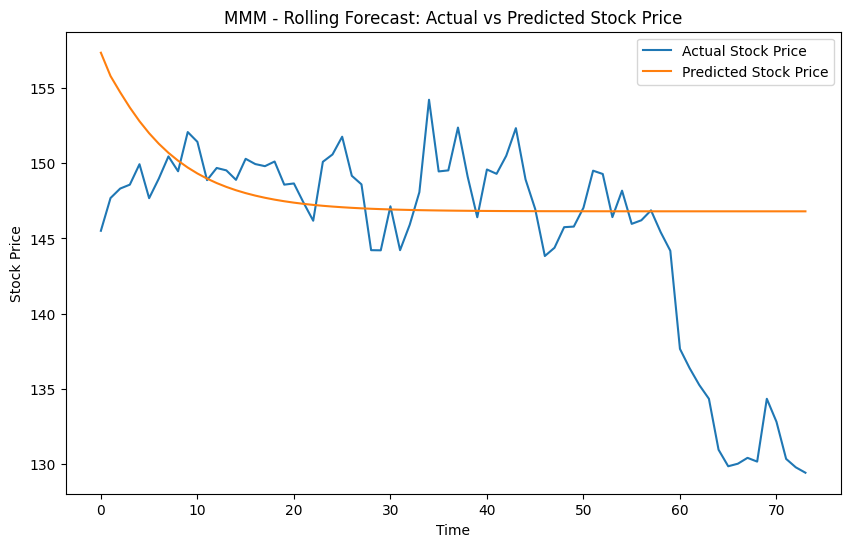

Mean Squared Error (MSE): 49.90376120152307
Root Mean Squared Error (RMSE): 7.064259423430249
Mean Absolute Percentage Error (MAPE): 3.407548655140803%


In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load and preprocess the dataset
data = pd.read_csv("C:/Users/tanxi/Downloads/company_stock_details.csv", low_memory=False)

# Filter data for "MMM" ticker only
data_filtered = data[data['Symbol'] == "MMM"]

# Select relevant columns and add additional feature engineering
data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])  # Log transformation of target variable
data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()  # 7-day moving average
data_filtered['Close_MA30'] = data_filtered['Close'].rolling(window=30).mean()  # 30-day moving average
data_filtered = data_filtered[['Close_Log', 'Volume', 'News - Positive Sentiment', 'News - Negative Sentiment', 
                               'News - New Products', 'News - Analyst Comments', 'News - Adverse Events', 
                               'Close_MA7', 'Close_MA30']].dropna()

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_filtered)

# Define function to create sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # Predicting the 'Close_Log' (log-transformed close price)
    return np.array(X), np.array(y)

# Hyperparameter adjustments
sequence_length = 45  # Adjusted sequence length
hidden_layer_size = 384  # Adjusted hidden layer size
num_layers = 1  # Simplified to 1 layer
dropout_rate = 0.2
learning_rate = 0.00005  # Slightly higher learning rate
batch_size = 16  # Increased batch size

# Create sequences
X, y = create_sequences(scaled_data, sequence_length)

# Split into train and validation sets
split_index = int(len(X) * 0.8)
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]

# Convert to tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

# Define Simplified Bidirectional LSTM Model
class SimpleBidirectionalLSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size=hidden_layer_size, output_size=1, num_layers=num_layers):
        super(SimpleBidirectionalLSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.bidirectional_lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True, 
                                          dropout=dropout_rate, bidirectional=True)
        self.linear = nn.Linear(hidden_layer_size * 2, output_size)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_layer_size).requires_grad_()
        c_0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_layer_size).requires_grad_()
        
        lstm_out, _ = self.bidirectional_lstm(x, (h_0, c_0))
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

# Instantiate and train the model
input_size = data_filtered.shape[1]
model = SimpleBidirectionalLSTM(input_size=input_size)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Implement early stopping
early_stopping_patience = 10
min_val_loss = np.inf
early_stop_counter = 0

# Training loop with increased epochs
epochs = 150
for epoch in range(epochs):
    model.train()
    for i in range(0, len(X_train_tensor), batch_size):
        X_batch = X_train_tensor[i:i+batch_size]
        y_batch = y_train_tensor[i:i+batch_size]
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_function(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        X_val_tensor = torch.from_numpy(X_val).float()
        y_val_tensor = torch.from_numpy(y_val).float()
        y_pred_val = model(X_val_tensor)
        val_loss = loss_function(y_pred_val, y_val_tensor.unsqueeze(1)).item()
    
    # Print losses
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {loss.item()}, Validation Loss: {val_loss}")
    
    # Scheduler step
    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break

# Rolling forecast on validation data
model.eval()
rolling_predictions = []
current_sequence = X_val[0]  # Start with the first sequence in validation data

with torch.no_grad():
    for i in range(len(X_val)):
        current_sequence_tensor = torch.from_numpy(current_sequence).float().unsqueeze(0)
        prediction = model(current_sequence_tensor)
        rolling_predictions.append(prediction.item())

        # Update sequence by appending the prediction and removing the oldest element
        new_prediction = np.array([[prediction.item()] + [0] * (current_sequence.shape[1] - 1)])
        new_sequence = np.vstack((current_sequence[1:], new_prediction))
        current_sequence = new_sequence

# Rescale and evaluate, converting back from log scale
actual_values_rescaled = np.expm1(scaler.inverse_transform(
    np.concatenate([y_val.reshape(-1, 1), np.zeros((len(y_val), input_size - 1))], axis=1))[:, 0])
rolling_predictions_rescaled = np.expm1(scaler.inverse_transform(
    np.concatenate([np.array(rolling_predictions).reshape(-1, 1), np.zeros((len(rolling_predictions), input_size - 1))], axis=1))[:, 0])

# Plot the actual and predicted stock prices for "MMM"
plt.figure(figsize=(10, 6))
plt.plot(actual_values_rescaled, label='Actual Stock Price')
plt.plot(rolling_predictions_rescaled, label='Predicted Stock Price')
plt.title('MMM - Rolling Forecast: Actual vs Predicted Stock Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Calculate and print error metrics
mse = mean_squared_error(actual_values_rescaled, rolling_predictions_rescaled)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_values_rescaled - rolling_predictions_rescaled) / actual_values_rescaled)) * 100

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


Rolling forecast applied on LSTM model for predictions of our 10 selected companies


Processing ticker: XOM


C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch 1/150 - XOM - Training Loss: 0.4728, Validation Loss: 0.5508
Epoch 2/150 - XOM - Training Loss: 0.3091, Validation Loss: 0.3581
Epoch 3/150 - XOM - Training Loss: 0.1253, Validation Loss: 0.1370
Epoch 4/150 - XOM - Training Loss: 0.0126, Validation Loss: 0.0100
Epoch 5/150 - XOM - Training Loss: 0.0425, Validation Loss: 0.0470
Epoch 6/150 - XOM - Training Loss: 0.0293, Validation Loss: 0.0293
Epoch 7/150 - XOM - Training Loss: 0.0272, Validation Loss: 0.0273
Epoch 8/150 - XOM - Training Loss: 0.0273, Validation Loss: 0.0266
Epoch 9/150 - XOM - Training Loss: 0.0233, Validation Loss: 0.0236
Epoch 10/150 - XOM - Training Loss: 0.0225, Validation Loss: 0.0225
Epoch 11/150 - XOM - Training Loss: 0.0221, Validation Loss: 0.0218
Epoch 12/150 - XOM - Training Loss: 0.0216, Validation Loss: 0.0208
Epoch 13/150 - XOM - Training Loss: 0.0202, Validation Loss: 0.0199
Epoch 14/150 - XOM - Training Loss: 0.0197, Validation Loss: 0.0193
Early stopping triggered for XOM


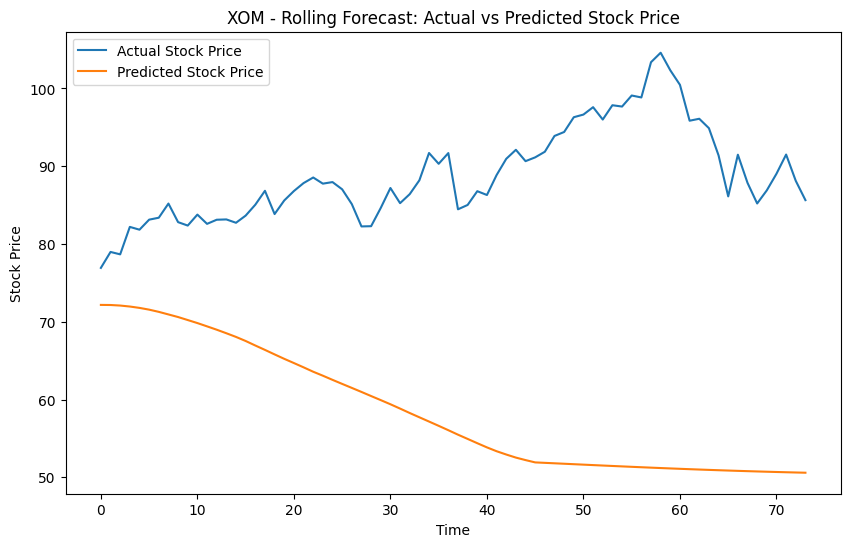


Processing ticker: SHW


C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch 1/150 - SHW - Training Loss: 0.0094, Validation Loss: 0.0775
Epoch 2/150 - SHW - Training Loss: 0.0011, Validation Loss: 0.0417
Epoch 3/150 - SHW - Training Loss: 0.0279, Validation Loss: 0.0219
Epoch 4/150 - SHW - Training Loss: 0.1469, Validation Loss: 0.0474
Epoch 5/150 - SHW - Training Loss: 0.2342, Validation Loss: 0.0744
Epoch 6/150 - SHW - Training Loss: 0.2040, Validation Loss: 0.0617
Epoch 7/150 - SHW - Training Loss: 0.1906, Validation Loss: 0.0565
Epoch 8/150 - SHW - Training Loss: 0.1864, Validation Loss: 0.0548
Epoch 9/150 - SHW - Training Loss: 0.1833, Validation Loss: 0.0534
Epoch 10/150 - SHW - Training Loss: 0.1815, Validation Loss: 0.0524
Epoch 11/150 - SHW - Training Loss: 0.1803, Validation Loss: 0.0516
Epoch 12/150 - SHW - Training Loss: 0.1783, Validation Loss: 0.0509
Epoch 13/150 - SHW - Training Loss: 0.1766, Validation Loss: 0.0502
Early stopping triggered for SHW


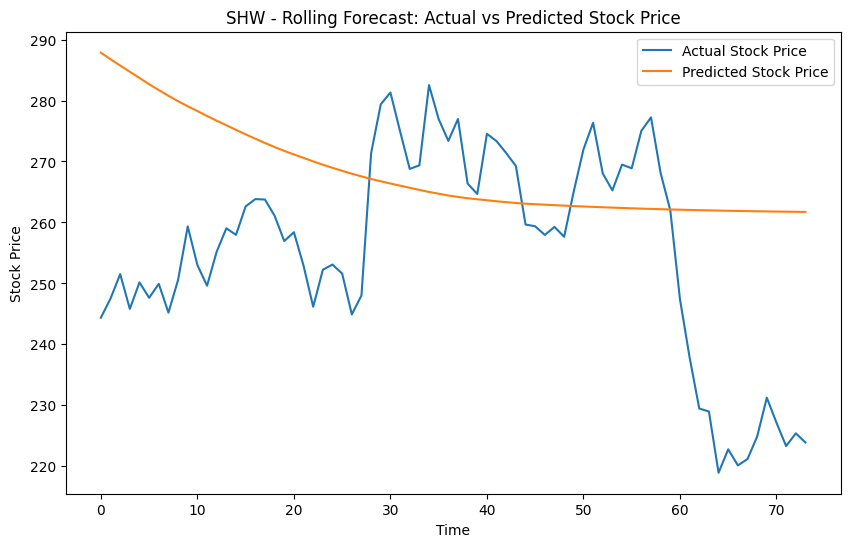


Processing ticker: AMZN


C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch 1/150 - AMZN - Training Loss: 0.1998, Validation Loss: 0.1517
Epoch 2/150 - AMZN - Training Loss: 0.1010, Validation Loss: 0.0972
Epoch 3/150 - AMZN - Training Loss: 0.0097, Validation Loss: 0.0702
Epoch 4/150 - AMZN - Training Loss: 0.0438, Validation Loss: 0.1393
Epoch 5/150 - AMZN - Training Loss: 0.0198, Validation Loss: 0.1176
Epoch 6/150 - AMZN - Training Loss: 0.0266, Validation Loss: 0.1249
Epoch 7/150 - AMZN - Training Loss: 0.0241, Validation Loss: 0.1226
Epoch 8/150 - AMZN - Training Loss: 0.0224, Validation Loss: 0.1220
Epoch 9/150 - AMZN - Training Loss: 0.0225, Validation Loss: 0.1221
Epoch 10/150 - AMZN - Training Loss: 0.0225, Validation Loss: 0.1221
Epoch 11/150 - AMZN - Training Loss: 0.0224, Validation Loss: 0.1220
Epoch 12/150 - AMZN - Training Loss: 0.0215, Validation Loss: 0.1215
Epoch 13/150 - AMZN - Training Loss: 0.0214, Validation Loss: 0.1215
Early stopping triggered for AMZN


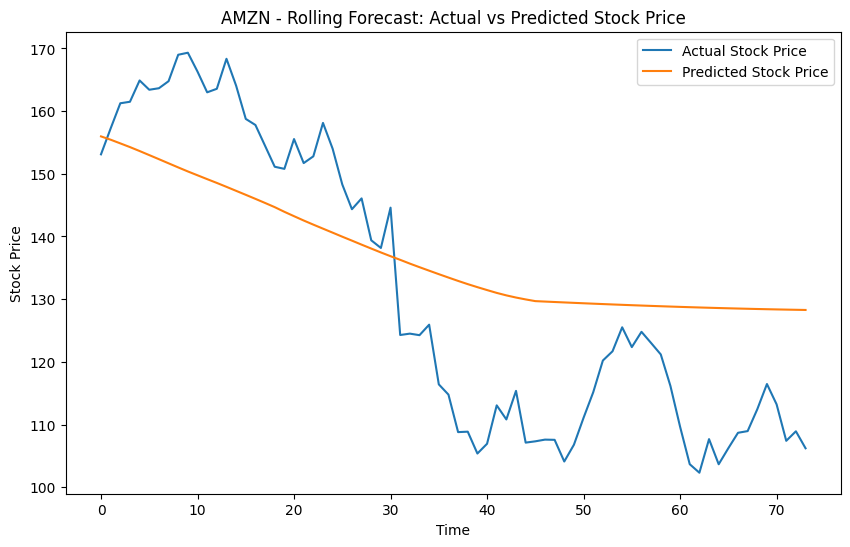


Processing ticker: PG


C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch 1/150 - PG - Training Loss: 0.2476, Validation Loss: 0.3724
Epoch 2/150 - PG - Training Loss: 0.1326, Validation Loss: 0.2364
Epoch 3/150 - PG - Training Loss: 0.0321, Validation Loss: 0.1015
Epoch 4/150 - PG - Training Loss: 0.0160, Validation Loss: 0.0308
Epoch 5/150 - PG - Training Loss: 0.0267, Validation Loss: 0.0312
Epoch 6/150 - PG - Training Loss: 0.0211, Validation Loss: 0.0305
Epoch 7/150 - PG - Training Loss: 0.0271, Validation Loss: 0.0308
Epoch 8/150 - PG - Training Loss: 0.0331, Validation Loss: 0.0316
Epoch 9/150 - PG - Training Loss: 0.0363, Validation Loss: 0.0320
Epoch 10/150 - PG - Training Loss: 0.0409, Validation Loss: 0.0329
Epoch 11/150 - PG - Training Loss: 0.0422, Validation Loss: 0.0327
Epoch 12/150 - PG - Training Loss: 0.0416, Validation Loss: 0.0325
Epoch 13/150 - PG - Training Loss: 0.0430, Validation Loss: 0.0328
Epoch 14/150 - PG - Training Loss: 0.0453, Validation Loss: 0.0332
Epoch 15/150 - PG - Training Loss: 0.0462, Validation Loss: 0.0333
Epoc

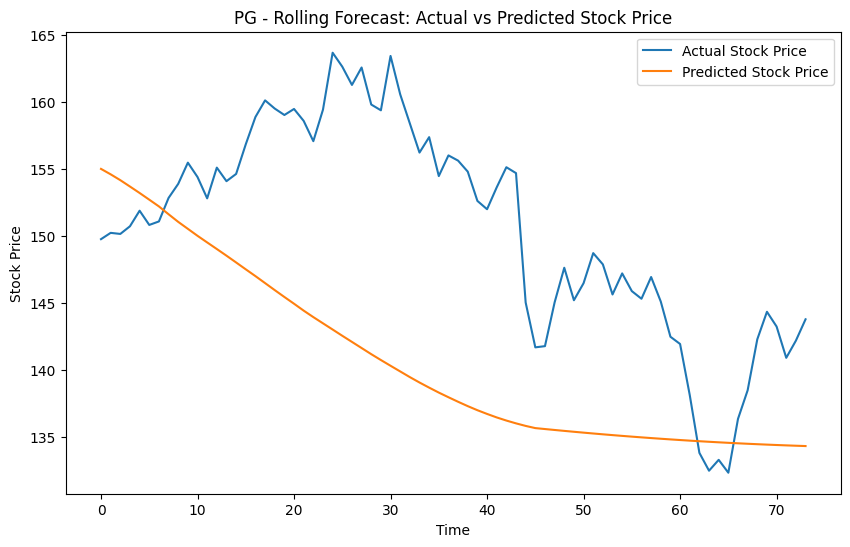


Processing ticker: JNJ


C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch 1/150 - JNJ - Training Loss: 0.3407, Validation Loss: 0.5090
Epoch 2/150 - JNJ - Training Loss: 0.2095, Validation Loss: 0.3283
Epoch 3/150 - JNJ - Training Loss: 0.0699, Validation Loss: 0.1236
Epoch 4/150 - JNJ - Training Loss: 0.0044, Validation Loss: 0.0194
Epoch 5/150 - JNJ - Training Loss: 0.0117, Validation Loss: 0.0379
Epoch 6/150 - JNJ - Training Loss: 0.0108, Validation Loss: 0.0351
Epoch 7/150 - JNJ - Training Loss: 0.0099, Validation Loss: 0.0339
Epoch 8/150 - JNJ - Training Loss: 0.0105, Validation Loss: 0.0351
Epoch 9/150 - JNJ - Training Loss: 0.0100, Validation Loss: 0.0341
Epoch 10/150 - JNJ - Training Loss: 0.0098, Validation Loss: 0.0337
Epoch 11/150 - JNJ - Training Loss: 0.0098, Validation Loss: 0.0340
Epoch 12/150 - JNJ - Training Loss: 0.0099, Validation Loss: 0.0341
Epoch 13/150 - JNJ - Training Loss: 0.0098, Validation Loss: 0.0340
Epoch 14/150 - JNJ - Training Loss: 0.0097, Validation Loss: 0.0338
Early stopping triggered for JNJ


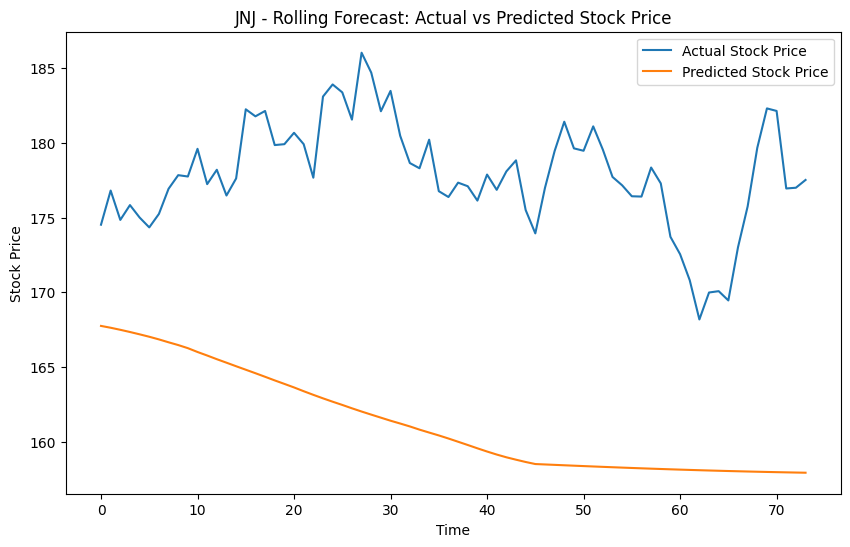


Processing ticker: JPM


C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch 1/150 - JPM - Training Loss: 0.0702, Validation Loss: 0.0548
Epoch 2/150 - JPM - Training Loss: 0.0150, Validation Loss: 0.0235
Epoch 3/150 - JPM - Training Loss: 0.0174, Validation Loss: 0.0422
Epoch 4/150 - JPM - Training Loss: 0.2790, Validation Loss: 0.2088
Epoch 5/150 - JPM - Training Loss: 0.1707, Validation Loss: 0.1475
Epoch 6/150 - JPM - Training Loss: 0.1898, Validation Loss: 0.1613
Epoch 7/150 - JPM - Training Loss: 0.1765, Validation Loss: 0.1549
Epoch 8/150 - JPM - Training Loss: 0.1729, Validation Loss: 0.1527
Epoch 9/150 - JPM - Training Loss: 0.1736, Validation Loss: 0.1529
Epoch 10/150 - JPM - Training Loss: 0.1725, Validation Loss: 0.1520
Epoch 11/150 - JPM - Training Loss: 0.1683, Validation Loss: 0.1504
Epoch 12/150 - JPM - Training Loss: 0.1670, Validation Loss: 0.1494
Early stopping triggered for JPM


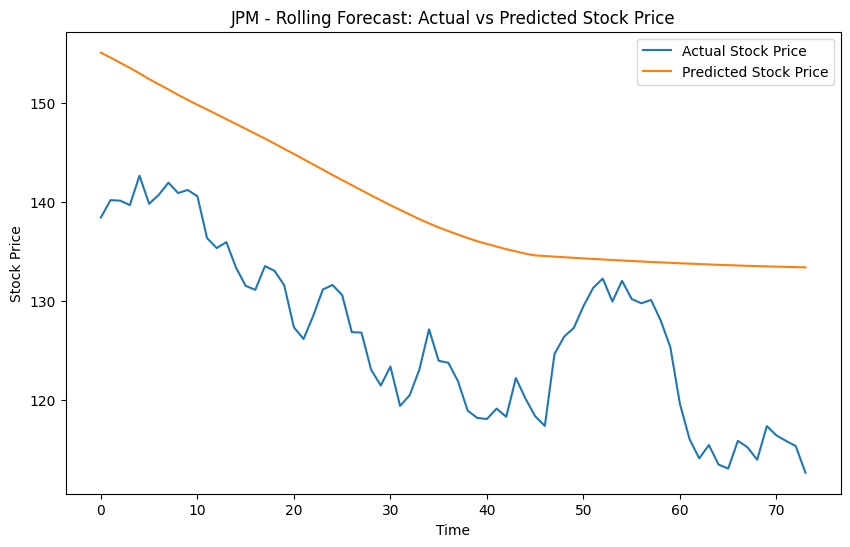


Processing ticker: AAPL


C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch 1/150 - AAPL - Training Loss: 0.2856, Validation Loss: 0.2825
Epoch 2/150 - AAPL - Training Loss: 0.1603, Validation Loss: 0.1672
Epoch 3/150 - AAPL - Training Loss: 0.0491, Validation Loss: 0.0662
Epoch 4/150 - AAPL - Training Loss: 0.0030, Validation Loss: 0.0301
Epoch 5/150 - AAPL - Training Loss: 0.0048, Validation Loss: 0.0308
Epoch 6/150 - AAPL - Training Loss: 0.0040, Validation Loss: 0.0293
Epoch 7/150 - AAPL - Training Loss: 0.0061, Validation Loss: 0.0301
Epoch 8/150 - AAPL - Training Loss: 0.0091, Validation Loss: 0.0314
Epoch 9/150 - AAPL - Training Loss: 0.0118, Validation Loss: 0.0323
Epoch 10/150 - AAPL - Training Loss: 0.0151, Validation Loss: 0.0334
Epoch 11/150 - AAPL - Training Loss: 0.0163, Validation Loss: 0.0331
Epoch 12/150 - AAPL - Training Loss: 0.0162, Validation Loss: 0.0326
Epoch 13/150 - AAPL - Training Loss: 0.0175, Validation Loss: 0.0330
Epoch 14/150 - AAPL - Training Loss: 0.0190, Validation Loss: 0.0334
Epoch 15/150 - AAPL - Training Loss: 0.0195

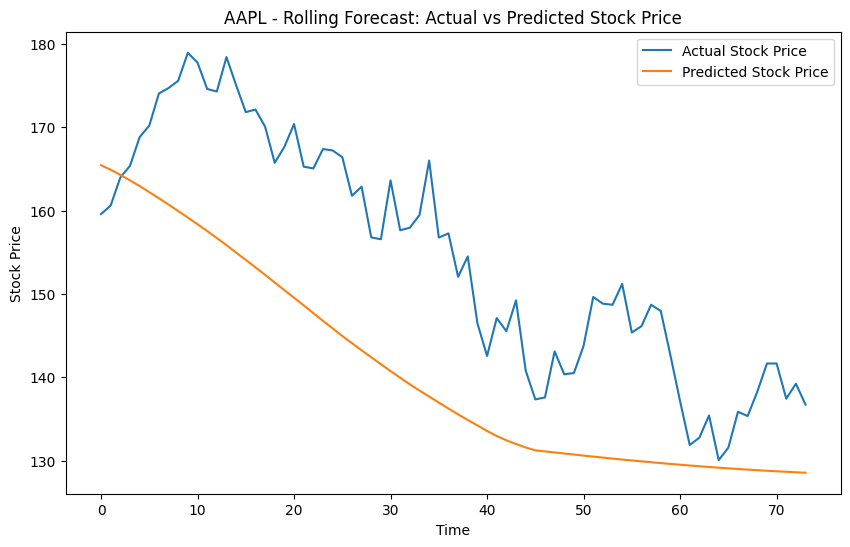


Processing ticker: GOOGL


C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch 1/150 - GOOGL - Training Loss: 0.3824, Validation Loss: 0.2567
Epoch 2/150 - GOOGL - Training Loss: 0.2316, Validation Loss: 0.1468
Epoch 3/150 - GOOGL - Training Loss: 0.0672, Validation Loss: 0.0404
Epoch 4/150 - GOOGL - Training Loss: 0.0412, Validation Loss: 0.0816
Epoch 5/150 - GOOGL - Training Loss: 0.0059, Validation Loss: 0.0404
Epoch 6/150 - GOOGL - Training Loss: 0.0114, Validation Loss: 0.0465
Epoch 7/150 - GOOGL - Training Loss: 0.0105, Validation Loss: 0.0438
Epoch 8/150 - GOOGL - Training Loss: 0.0114, Validation Loss: 0.0434
Epoch 9/150 - GOOGL - Training Loss: 0.0116, Validation Loss: 0.0424
Epoch 10/150 - GOOGL - Training Loss: 0.0085, Validation Loss: 0.0383
Epoch 11/150 - GOOGL - Training Loss: 0.0083, Validation Loss: 0.0378
Epoch 12/150 - GOOGL - Training Loss: 0.0090, Validation Loss: 0.0382
Epoch 13/150 - GOOGL - Training Loss: 0.0089, Validation Loss: 0.0376
Epoch 14/150 - GOOGL - Training Loss: 0.0090, Validation Loss: 0.0374
Epoch 15/150 - GOOGL - Traini

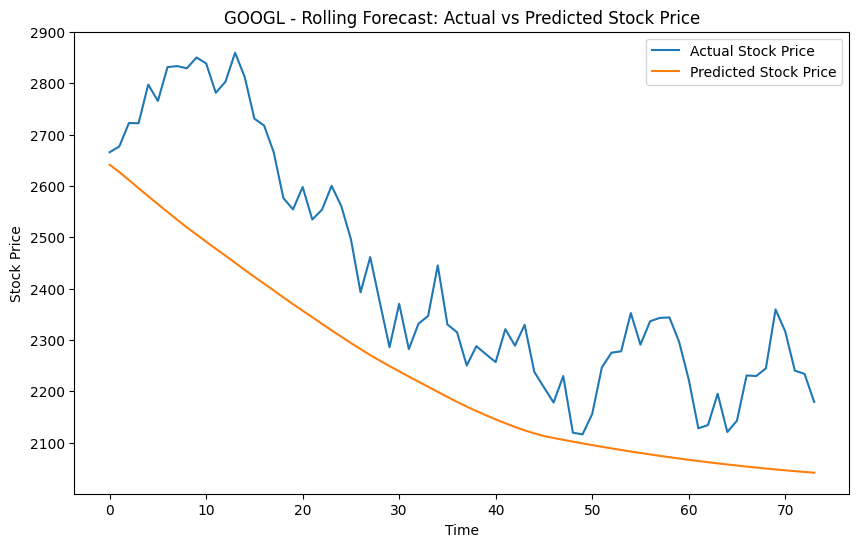


Processing ticker: NEE


C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch 1/150 - NEE - Training Loss: 0.1918, Validation Loss: 0.1454
Epoch 2/150 - NEE - Training Loss: 0.1086, Validation Loss: 0.0921
Epoch 3/150 - NEE - Training Loss: 0.0332, Validation Loss: 0.0552
Epoch 4/150 - NEE - Training Loss: 0.0017, Validation Loss: 0.0668
Epoch 5/150 - NEE - Training Loss: 0.0022, Validation Loss: 0.0687
Epoch 6/150 - NEE - Training Loss: 0.0017, Validation Loss: 0.0640
Epoch 7/150 - NEE - Training Loss: 0.0017, Validation Loss: 0.0638
Epoch 8/150 - NEE - Training Loss: 0.0017, Validation Loss: 0.0638
Epoch 9/150 - NEE - Training Loss: 0.0017, Validation Loss: 0.0637
Epoch 10/150 - NEE - Training Loss: 0.0017, Validation Loss: 0.0635
Epoch 11/150 - NEE - Training Loss: 0.0017, Validation Loss: 0.0634
Epoch 12/150 - NEE - Training Loss: 0.0017, Validation Loss: 0.0634
Epoch 13/150 - NEE - Training Loss: 0.0017, Validation Loss: 0.0632
Early stopping triggered for NEE


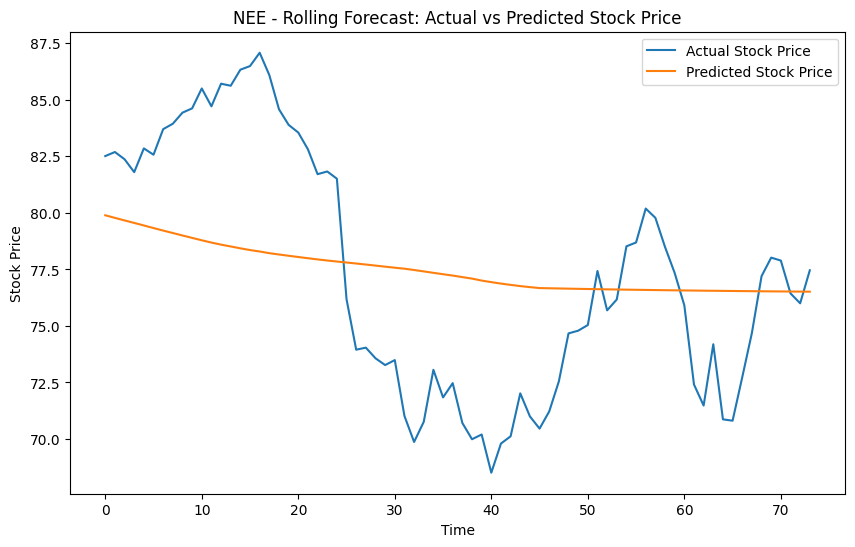


Processing ticker: AMT


C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\2375093861.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch 1/150 - AMT - Training Loss: 0.0813, Validation Loss: 0.2006
Epoch 2/150 - AMT - Training Loss: 0.0283, Validation Loss: 0.1152
Epoch 3/150 - AMT - Training Loss: 0.0004, Validation Loss: 0.0352
Epoch 4/150 - AMT - Training Loss: 0.0728, Validation Loss: 0.0216
Epoch 5/150 - AMT - Training Loss: 0.0580, Validation Loss: 0.0169
Epoch 6/150 - AMT - Training Loss: 0.0452, Validation Loss: 0.0151
Epoch 7/150 - AMT - Training Loss: 0.0491, Validation Loss: 0.0158
Epoch 8/150 - AMT - Training Loss: 0.0467, Validation Loss: 0.0155
Epoch 9/150 - AMT - Training Loss: 0.0446, Validation Loss: 0.0153
Epoch 10/150 - AMT - Training Loss: 0.0434, Validation Loss: 0.0152
Epoch 11/150 - AMT - Training Loss: 0.0398, Validation Loss: 0.0150
Epoch 12/150 - AMT - Training Loss: 0.0382, Validation Loss: 0.0149
Epoch 13/150 - AMT - Training Loss: 0.0378, Validation Loss: 0.0149
Epoch 14/150 - AMT - Training Loss: 0.0374, Validation Loss: 0.0149
Epoch 15/150 - AMT - Training Loss: 0.0369, Validation Lo

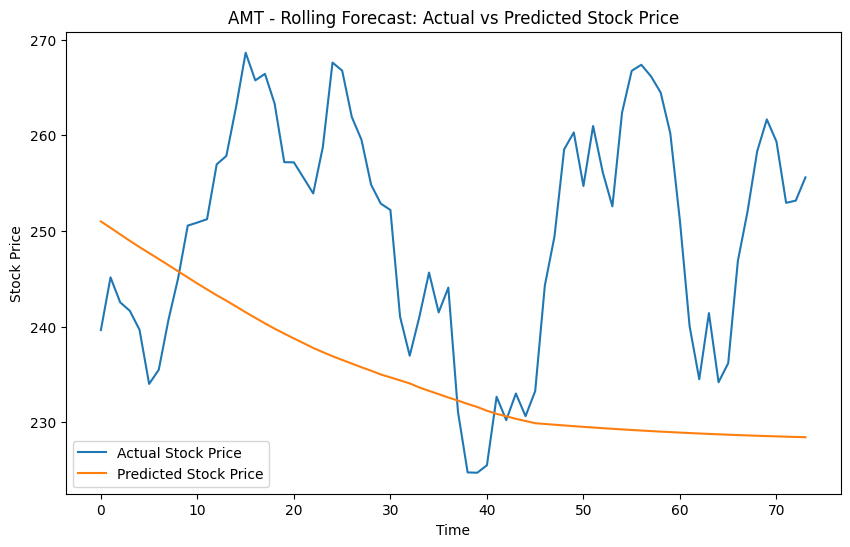

Ticker: XOM
Mean Squared Error (MSE): 1085.1610487481262
Root Mean Squared Error (RMSE): 32.94178271964233
Mean Absolute Percentage Error (MAPE): 33.34654011699128%


Ticker: SHW
Mean Squared Error (MSE): 510.9414357071832
Root Mean Squared Error (RMSE): 22.604013707905576
Mean Absolute Percentage Error (MAPE): 7.600768231539032%


Ticker: AMZN
Mean Squared Error (MSE): 253.89668422569196
Root Mean Squared Error (RMSE): 15.934135816720403
Mean Absolute Percentage Error (MAPE): 11.829360651246768%


Ticker: PG
Mean Squared Error (MSE): 150.0367622559592
Root Mean Squared Error (RMSE): 12.24894943478661
Mean Absolute Percentage Error (MAPE): 6.904558608264569%


Ticker: JNJ
Mean Squared Error (MSE): 295.38313857602367
Root Mean Squared Error (RMSE): 17.186714013330867
Mean Absolute Percentage Error (MAPE): 9.30059543256686%


Ticker: JPM
Mean Squared Error (MSE): 205.4325048920479
Root Mean Squared Error (RMSE): 14.332916831268083
Mean Absolute Percentage Error (MAPE): 10.868026144970765

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# List of tickers
tickers = ["XOM", "SHW", "AMZN", "PG", "JNJ", "JPM", "AAPL", "GOOGL", "NEE", "AMT"]

# Load and preprocess the dataset
data = pd.read_csv("C:/Users/tanxi/Downloads/company_stock_details.csv", low_memory=False)

# Initialize results dictionary to store results for each company
results = {}

# Define the Attention LSTM model
class AttentionLSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size=1, num_layers=1):
        super(AttentionLSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True, bidirectional=True)
        self.attention = nn.Linear(hidden_layer_size * 2, 1)
        self.linear = nn.Linear(hidden_layer_size * 2, output_size)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_layer_size).requires_grad_()
        c_0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_layer_size).requires_grad_()

        lstm_out, _ = self.lstm(x, (h_0, c_0))  # LSTM output
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)  # Compute attention weights
        context = torch.sum(attn_weights * lstm_out, dim=1)  # Weighted sum
        predictions = self.linear(context)
        return predictions

# Define function to create sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # Predicting the 'Close_Log' (log-transformed close price)
    return np.array(X), np.array(y)

# Hyperparameters
sequence_length = 45
hidden_layer_size = 384
num_layers = 1
dropout_rate = 0.2
learning_rate = 0.00005
batch_size = 16
epochs = 150
early_stopping_patience = 10

# Loop through each ticker and train an individual model
for ticker in tickers:
    print(f"\nProcessing ticker: {ticker}")
    
    # Filter data for specific ticker
    data_filtered = data[data['Symbol'] == ticker]

    # Feature engineering
    data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
    data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
    data_filtered['Close_MA30'] = data_filtered['Close'].rolling(window=30).mean()
    data_filtered = data_filtered[['Close_Log', 'Volume', 'News - Positive Sentiment', 'News - Negative Sentiment', 
                                   'News - New Products', 'News - Analyst Comments', 'News - Adverse Events', 
                                   'Close_MA7', 'Close_MA30']].dropna()

    # Scale data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data_filtered)

    # Create sequences
    X, y = create_sequences(scaled_data, sequence_length)

    # Split into train and validation sets
    split_index = int(len(X) * 0.8)
    X_train, X_val = X[:split_index], X[split_index:]
    y_train, y_val = y[:split_index], y[split_index:]

    # Convert to tensors
    X_train_tensor = torch.from_numpy(X_train).float()
    y_train_tensor = torch.from_numpy(y_train).float()

    # Initialize the model, loss function, and optimizer
    input_size = data_filtered.shape[1]
    model = AttentionLSTM(input_size=input_size, hidden_layer_size=hidden_layer_size)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    # Early stopping setup
    min_val_loss = np.inf
    early_stop_counter = 0

    # Training loop
    for epoch in range(epochs):
        model.train()
        for i in range(0, len(X_train_tensor), batch_size):
            X_batch = X_train_tensor[i:i+batch_size]
            y_batch = y_train_tensor[i:i+batch_size]
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_function(y_pred, y_batch.unsqueeze(1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            X_val_tensor = torch.from_numpy(X_val).float()
            y_val_tensor = torch.from_numpy(y_val).float()
            y_pred_val = model(X_val_tensor)
            val_loss = loss_function(y_pred_val, y_val_tensor.unsqueeze(1)).item()
        
        print(f"Epoch {epoch+1}/{epochs} - {ticker} - Training Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}")
        
        # Scheduler step
        scheduler.step(val_loss)

        # Early stopping check
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= early_stopping_patience:
                print(f"Early stopping triggered for {ticker}")
                break

    # Rolling forecast on validation data
    model.eval()
    rolling_predictions = []
    current_sequence = X_val[0]  # Start with the first sequence in validation data

    with torch.no_grad():
        for i in range(len(X_val)):
            current_sequence_tensor = torch.from_numpy(current_sequence).float().unsqueeze(0)
            prediction = model(current_sequence_tensor)
            rolling_predictions.append(prediction.item())

            # Update sequence by appending the prediction and removing the oldest element
            new_prediction = np.array([[prediction.item()] + [0] * (current_sequence.shape[1] - 1)])
            new_sequence = np.vstack((current_sequence[1:], new_prediction))
            current_sequence = new_sequence

    # Rescale and evaluate
    actual_values_rescaled = np.expm1(scaler.inverse_transform(
        np.concatenate([y_val.reshape(-1, 1), np.zeros((len(y_val), input_size - 1))], axis=1))[:, 0])
    rolling_predictions_rescaled = np.expm1(scaler.inverse_transform(
        np.concatenate([np.array(rolling_predictions).reshape(-1, 1), np.zeros((len(rolling_predictions), input_size - 1))], axis=1))[:, 0])

    # Calculate error metrics
    mse = mean_squared_error(actual_values_rescaled, rolling_predictions_rescaled)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual_values_rescaled - rolling_predictions_rescaled) / actual_values_rescaled)) * 100

    # Store results for the ticker
    results[ticker] = {
        "MSE": mse,
        "RMSE": rmse,
        "MAPE": mape,
        "Actual": actual_values_rescaled,
        "Predicted": rolling_predictions_rescaled
    }

    # Plot for each company
    plt.figure(figsize=(10, 6))
    plt.plot(actual_values_rescaled, label='Actual Stock Price')
    plt.plot(rolling_predictions_rescaled, label='Predicted Stock Price')
    plt.title(f'{ticker} - Rolling Forecast: Actual vs Predicted Stock Price')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

# Print summary of results for each company
for ticker, metrics in results.items():
    print(f"Ticker: {ticker}")
    print(f"Mean Squared Error (MSE): {metrics['MSE']}")
    print(f"Root Mean Squared Error (RMSE): {metrics['RMSE']}")
    print(f"Mean Absolute Percentage Error (MAPE): {metrics['MAPE']}%")
    print("\n")


One-time prediction applied on LSTM model for predictions of the 10 companies chosen


Processing ticker: XOM


C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch 1/150 - XOM - Training Loss: 0.4165, Validation Loss: 0.4946
Epoch 2/150 - XOM - Training Loss: 0.2592, Validation Loss: 0.3078
Epoch 3/150 - XOM - Training Loss: 0.0940, Validation Loss: 0.1076
Epoch 4/150 - XOM - Training Loss: 0.0214, Validation Loss: 0.0249
Epoch 5/150 - XOM - Training Loss: 0.0397, Validation Loss: 0.0483
Epoch 6/150 - XOM - Training Loss: 0.0344, Validation Loss: 0.0398
Epoch 7/150 - XOM - Training Loss: 0.0308, Validation Loss: 0.0352
Epoch 8/150 - XOM - Training Loss: 0.0305, Validation Loss: 0.0340
Epoch 9/150 - XOM - Training Loss: 0.0270, Validation Loss: 0.0314
Epoch 10/150 - XOM - Training Loss: 0.0261, Validation Loss: 0.0299
Epoch 11/150 - XOM - Training Loss: 0.0255, Validation Loss: 0.0288
Epoch 12/150 - XOM - Training Loss: 0.0248, Validation Loss: 0.0276
Epoch 13/150 - XOM - Training Loss: 0.0234, Validation Loss: 0.0267
Epoch 14/150 - XOM - Training Loss: 0.0229, Validation Loss: 0.0259
Early stopping triggered for XOM


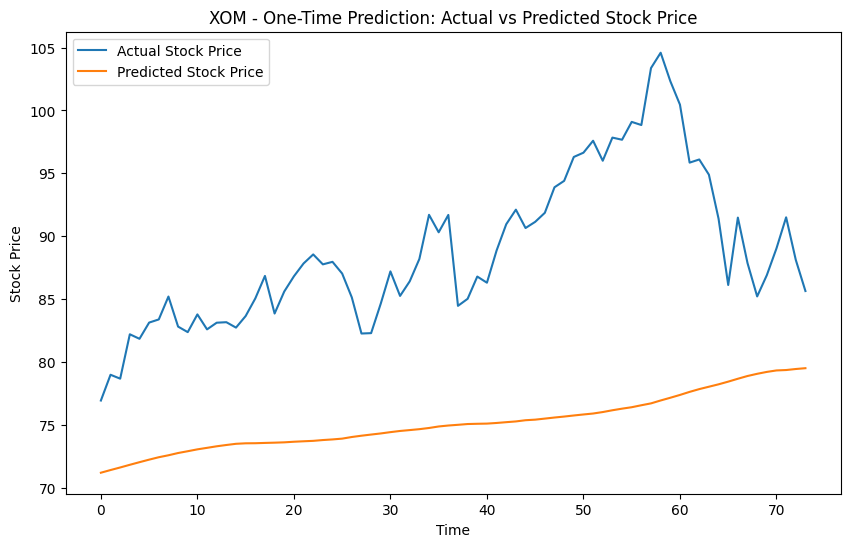


Processing ticker: SHW


C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch 1/150 - SHW - Training Loss: 0.0083, Validation Loss: 0.0766
Epoch 2/150 - SHW - Training Loss: 0.0017, Validation Loss: 0.0403
Epoch 3/150 - SHW - Training Loss: 0.0346, Validation Loss: 0.0221
Epoch 4/150 - SHW - Training Loss: 0.1579, Validation Loss: 0.0486
Epoch 5/150 - SHW - Training Loss: 0.2373, Validation Loss: 0.0720
Epoch 6/150 - SHW - Training Loss: 0.2093, Validation Loss: 0.0607
Epoch 7/150 - SHW - Training Loss: 0.1962, Validation Loss: 0.0559
Epoch 8/150 - SHW - Training Loss: 0.1917, Validation Loss: 0.0543
Epoch 9/150 - SHW - Training Loss: 0.1885, Validation Loss: 0.0530
Epoch 10/150 - SHW - Training Loss: 0.1866, Validation Loss: 0.0520
Epoch 11/150 - SHW - Training Loss: 0.1854, Validation Loss: 0.0513
Epoch 12/150 - SHW - Training Loss: 0.1835, Validation Loss: 0.0507
Epoch 13/150 - SHW - Training Loss: 0.1818, Validation Loss: 0.0501
Early stopping triggered for SHW


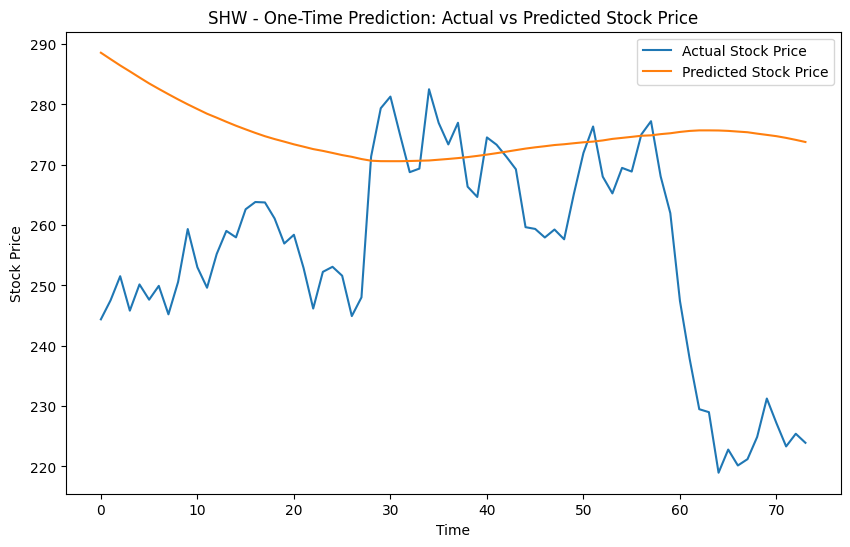


Processing ticker: AMZN


C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch 1/150 - AMZN - Training Loss: 0.2518, Validation Loss: 0.1828
Epoch 2/150 - AMZN - Training Loss: 0.1390, Validation Loss: 0.1162
Epoch 3/150 - AMZN - Training Loss: 0.0197, Validation Loss: 0.0685
Epoch 4/150 - AMZN - Training Loss: 0.0364, Validation Loss: 0.1297
Epoch 5/150 - AMZN - Training Loss: 0.0228, Validation Loss: 0.1227
Epoch 6/150 - AMZN - Training Loss: 0.0260, Validation Loss: 0.1238
Epoch 7/150 - AMZN - Training Loss: 0.0263, Validation Loss: 0.1258
Epoch 8/150 - AMZN - Training Loss: 0.0230, Validation Loss: 0.1232
Epoch 9/150 - AMZN - Training Loss: 0.0230, Validation Loss: 0.1233
Epoch 10/150 - AMZN - Training Loss: 0.0232, Validation Loss: 0.1236
Epoch 11/150 - AMZN - Training Loss: 0.0230, Validation Loss: 0.1234
Epoch 12/150 - AMZN - Training Loss: 0.0218, Validation Loss: 0.1226
Epoch 13/150 - AMZN - Training Loss: 0.0217, Validation Loss: 0.1225
Early stopping triggered for AMZN


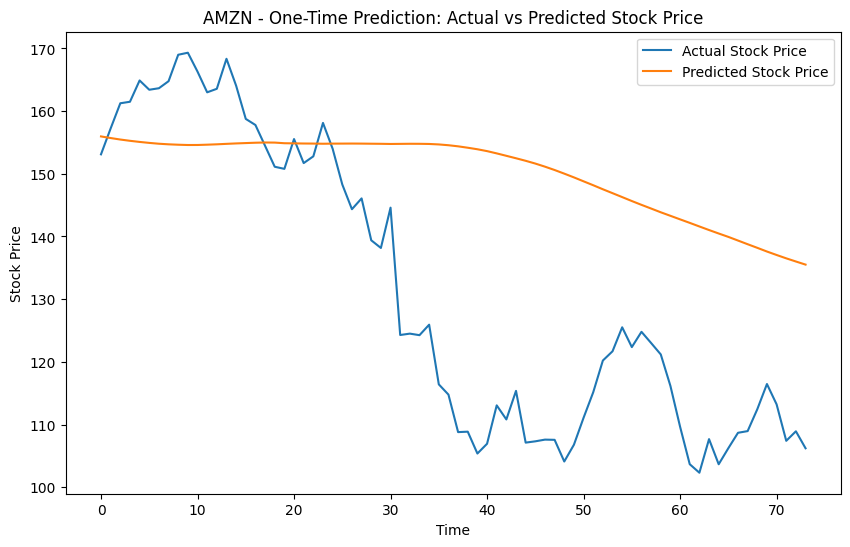


Processing ticker: PG


C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch 1/150 - PG - Training Loss: 0.2558, Validation Loss: 0.3780
Epoch 2/150 - PG - Training Loss: 0.1389, Validation Loss: 0.2411
Epoch 3/150 - PG - Training Loss: 0.0361, Validation Loss: 0.1054
Epoch 4/150 - PG - Training Loss: 0.0140, Validation Loss: 0.0307
Epoch 5/150 - PG - Training Loss: 0.0286, Validation Loss: 0.0319
Epoch 6/150 - PG - Training Loss: 0.0216, Validation Loss: 0.0306
Epoch 7/150 - PG - Training Loss: 0.0273, Validation Loss: 0.0312
Epoch 8/150 - PG - Training Loss: 0.0333, Validation Loss: 0.0322
Epoch 9/150 - PG - Training Loss: 0.0363, Validation Loss: 0.0327
Epoch 10/150 - PG - Training Loss: 0.0406, Validation Loss: 0.0336
Epoch 11/150 - PG - Training Loss: 0.0418, Validation Loss: 0.0335
Epoch 12/150 - PG - Training Loss: 0.0412, Validation Loss: 0.0332
Epoch 13/150 - PG - Training Loss: 0.0425, Validation Loss: 0.0335
Epoch 14/150 - PG - Training Loss: 0.0446, Validation Loss: 0.0340
Epoch 15/150 - PG - Training Loss: 0.0455, Validation Loss: 0.0341
Epoc

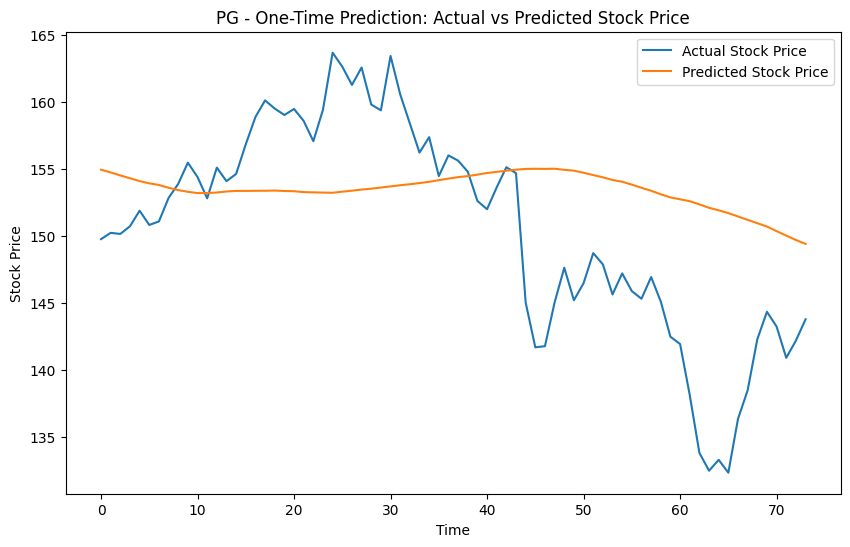


Processing ticker: JNJ


C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch 1/150 - JNJ - Training Loss: 0.3376, Validation Loss: 0.5100
Epoch 2/150 - JNJ - Training Loss: 0.2077, Validation Loss: 0.3317
Epoch 3/150 - JNJ - Training Loss: 0.0715, Validation Loss: 0.1318
Epoch 4/150 - JNJ - Training Loss: 0.0045, Validation Loss: 0.0213
Epoch 5/150 - JNJ - Training Loss: 0.0118, Validation Loss: 0.0413
Epoch 6/150 - JNJ - Training Loss: 0.0110, Validation Loss: 0.0384
Epoch 7/150 - JNJ - Training Loss: 0.0099, Validation Loss: 0.0365
Epoch 8/150 - JNJ - Training Loss: 0.0106, Validation Loss: 0.0379
Epoch 9/150 - JNJ - Training Loss: 0.0101, Validation Loss: 0.0371
Epoch 10/150 - JNJ - Training Loss: 0.0100, Validation Loss: 0.0367
Epoch 11/150 - JNJ - Training Loss: 0.0100, Validation Loss: 0.0368
Epoch 12/150 - JNJ - Training Loss: 0.0100, Validation Loss: 0.0369
Epoch 13/150 - JNJ - Training Loss: 0.0100, Validation Loss: 0.0368
Epoch 14/150 - JNJ - Training Loss: 0.0099, Validation Loss: 0.0367
Early stopping triggered for JNJ


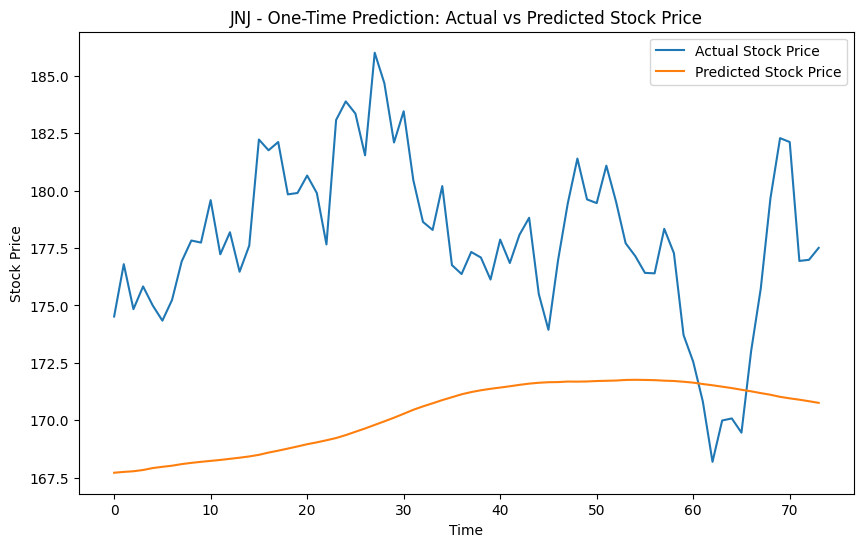


Processing ticker: JPM


C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch 1/150 - JPM - Training Loss: 0.0768, Validation Loss: 0.0597
Epoch 2/150 - JPM - Training Loss: 0.0180, Validation Loss: 0.0249
Epoch 3/150 - JPM - Training Loss: 0.0160, Validation Loss: 0.0403
Epoch 4/150 - JPM - Training Loss: 0.2756, Validation Loss: 0.2049
Epoch 5/150 - JPM - Training Loss: 0.1684, Validation Loss: 0.1454
Epoch 6/150 - JPM - Training Loss: 0.1875, Validation Loss: 0.1586
Epoch 7/150 - JPM - Training Loss: 0.1725, Validation Loss: 0.1515
Epoch 8/150 - JPM - Training Loss: 0.1697, Validation Loss: 0.1498
Epoch 9/150 - JPM - Training Loss: 0.1702, Validation Loss: 0.1499
Epoch 10/150 - JPM - Training Loss: 0.1689, Validation Loss: 0.1487
Epoch 11/150 - JPM - Training Loss: 0.1644, Validation Loss: 0.1471
Epoch 12/150 - JPM - Training Loss: 0.1632, Validation Loss: 0.1461
Early stopping triggered for JPM


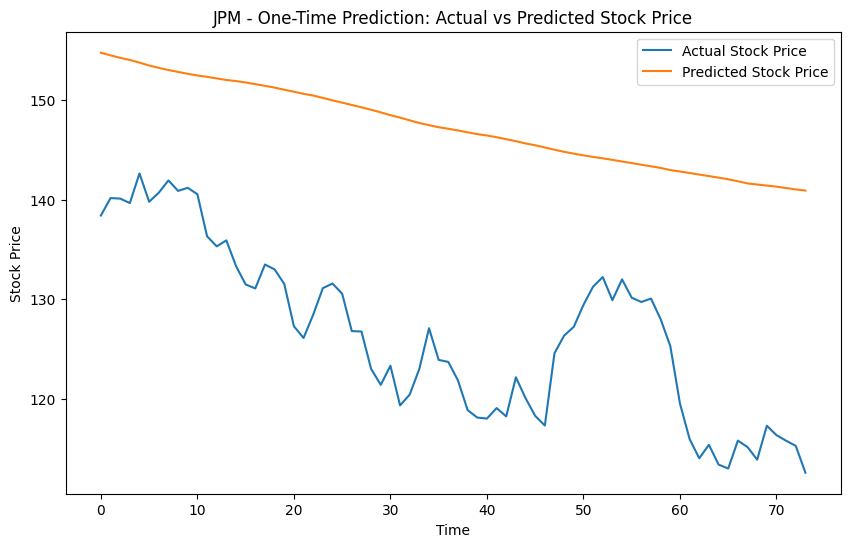


Processing ticker: AAPL


C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch 1/150 - AAPL - Training Loss: 0.3374, Validation Loss: 0.3286
Epoch 2/150 - AAPL - Training Loss: 0.2002, Validation Loss: 0.2026
Epoch 3/150 - AAPL - Training Loss: 0.0674, Validation Loss: 0.0816
Epoch 4/150 - AAPL - Training Loss: 0.0031, Validation Loss: 0.0313
Epoch 5/150 - AAPL - Training Loss: 0.0050, Validation Loss: 0.0318
Epoch 6/150 - AAPL - Training Loss: 0.0040, Validation Loss: 0.0299
Epoch 7/150 - AAPL - Training Loss: 0.0067, Validation Loss: 0.0312
Epoch 8/150 - AAPL - Training Loss: 0.0098, Validation Loss: 0.0324
Epoch 9/150 - AAPL - Training Loss: 0.0125, Validation Loss: 0.0332
Epoch 10/150 - AAPL - Training Loss: 0.0159, Validation Loss: 0.0344
Epoch 11/150 - AAPL - Training Loss: 0.0170, Validation Loss: 0.0339
Epoch 12/150 - AAPL - Training Loss: 0.0168, Validation Loss: 0.0334
Epoch 13/150 - AAPL - Training Loss: 0.0182, Validation Loss: 0.0337
Epoch 14/150 - AAPL - Training Loss: 0.0197, Validation Loss: 0.0342
Epoch 15/150 - AAPL - Training Loss: 0.0202

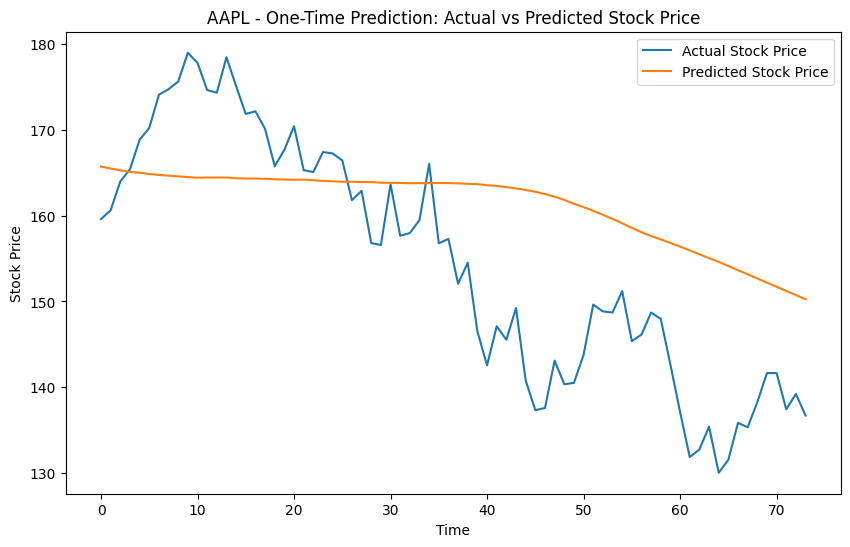


Processing ticker: GOOGL


C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch 1/150 - GOOGL - Training Loss: 0.4050, Validation Loss: 0.2757
Epoch 2/150 - GOOGL - Training Loss: 0.2514, Validation Loss: 0.1625
Epoch 3/150 - GOOGL - Training Loss: 0.0753, Validation Loss: 0.0455
Epoch 4/150 - GOOGL - Training Loss: 0.0494, Validation Loss: 0.0840
Epoch 5/150 - GOOGL - Training Loss: 0.0066, Validation Loss: 0.0398
Epoch 6/150 - GOOGL - Training Loss: 0.0131, Validation Loss: 0.0457
Epoch 7/150 - GOOGL - Training Loss: 0.0113, Validation Loss: 0.0426
Epoch 8/150 - GOOGL - Training Loss: 0.0125, Validation Loss: 0.0421
Epoch 9/150 - GOOGL - Training Loss: 0.0123, Validation Loss: 0.0410
Epoch 10/150 - GOOGL - Training Loss: 0.0091, Validation Loss: 0.0371
Epoch 11/150 - GOOGL - Training Loss: 0.0087, Validation Loss: 0.0365
Epoch 12/150 - GOOGL - Training Loss: 0.0095, Validation Loss: 0.0369
Epoch 13/150 - GOOGL - Training Loss: 0.0093, Validation Loss: 0.0363
Epoch 14/150 - GOOGL - Training Loss: 0.0094, Validation Loss: 0.0361
Epoch 15/150 - GOOGL - Traini

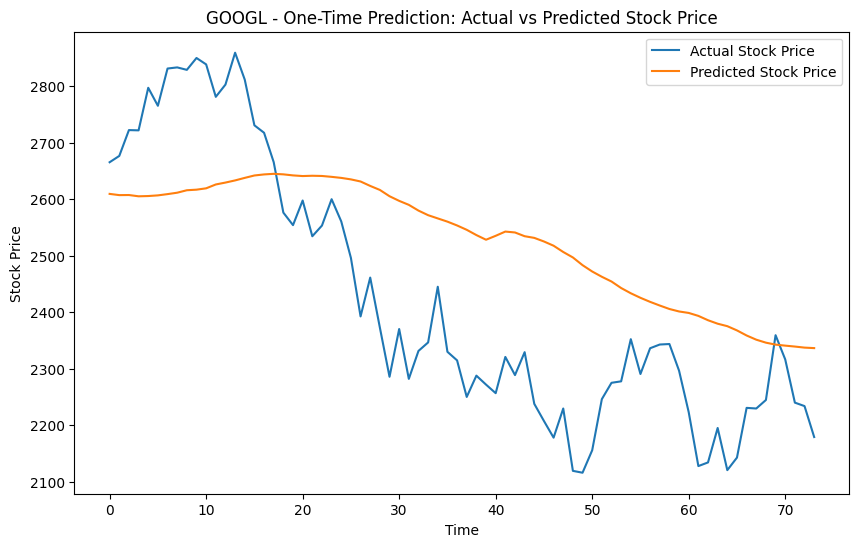


Processing ticker: NEE


C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch 1/150 - NEE - Training Loss: 0.1545, Validation Loss: 0.1220
Epoch 2/150 - NEE - Training Loss: 0.0830, Validation Loss: 0.0785
Epoch 3/150 - NEE - Training Loss: 0.0243, Validation Loss: 0.0532
Epoch 4/150 - NEE - Training Loss: 0.0017, Validation Loss: 0.0630
Epoch 5/150 - NEE - Training Loss: 0.0020, Validation Loss: 0.0666
Epoch 6/150 - NEE - Training Loss: 0.0017, Validation Loss: 0.0632
Epoch 7/150 - NEE - Training Loss: 0.0017, Validation Loss: 0.0624
Epoch 8/150 - NEE - Training Loss: 0.0017, Validation Loss: 0.0623
Epoch 9/150 - NEE - Training Loss: 0.0018, Validation Loss: 0.0622
Epoch 10/150 - NEE - Training Loss: 0.0018, Validation Loss: 0.0621
Epoch 11/150 - NEE - Training Loss: 0.0018, Validation Loss: 0.0620
Epoch 12/150 - NEE - Training Loss: 0.0018, Validation Loss: 0.0619
Epoch 13/150 - NEE - Training Loss: 0.0018, Validation Loss: 0.0618
Early stopping triggered for NEE


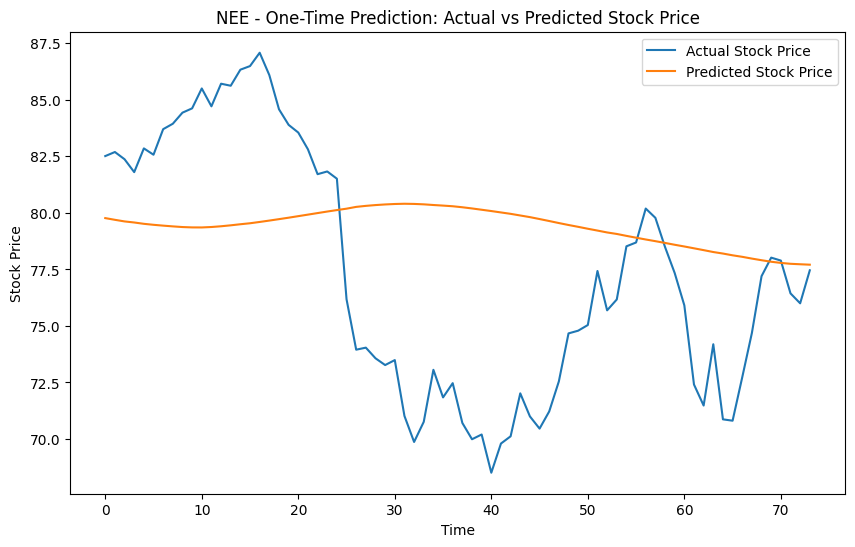


Processing ticker: AMT


C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
C:\Users\tanxi\AppData\Local\Temp\ipykernel_28664\3429015074.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Epoch 1/150 - AMT - Training Loss: 0.0937, Validation Loss: 0.2162
Epoch 2/150 - AMT - Training Loss: 0.0353, Validation Loss: 0.1252
Epoch 3/150 - AMT - Training Loss: 0.0003, Validation Loss: 0.0371
Epoch 4/150 - AMT - Training Loss: 0.0764, Validation Loss: 0.0243
Epoch 5/150 - AMT - Training Loss: 0.0514, Validation Loss: 0.0166
Epoch 6/150 - AMT - Training Loss: 0.0420, Validation Loss: 0.0154
Epoch 7/150 - AMT - Training Loss: 0.0465, Validation Loss: 0.0162
Epoch 8/150 - AMT - Training Loss: 0.0436, Validation Loss: 0.0158
Epoch 9/150 - AMT - Training Loss: 0.0418, Validation Loss: 0.0156
Epoch 10/150 - AMT - Training Loss: 0.0406, Validation Loss: 0.0156
Epoch 11/150 - AMT - Training Loss: 0.0366, Validation Loss: 0.0152
Epoch 12/150 - AMT - Training Loss: 0.0350, Validation Loss: 0.0151
Epoch 13/150 - AMT - Training Loss: 0.0346, Validation Loss: 0.0151
Epoch 14/150 - AMT - Training Loss: 0.0342, Validation Loss: 0.0152
Epoch 15/150 - AMT - Training Loss: 0.0337, Validation Lo

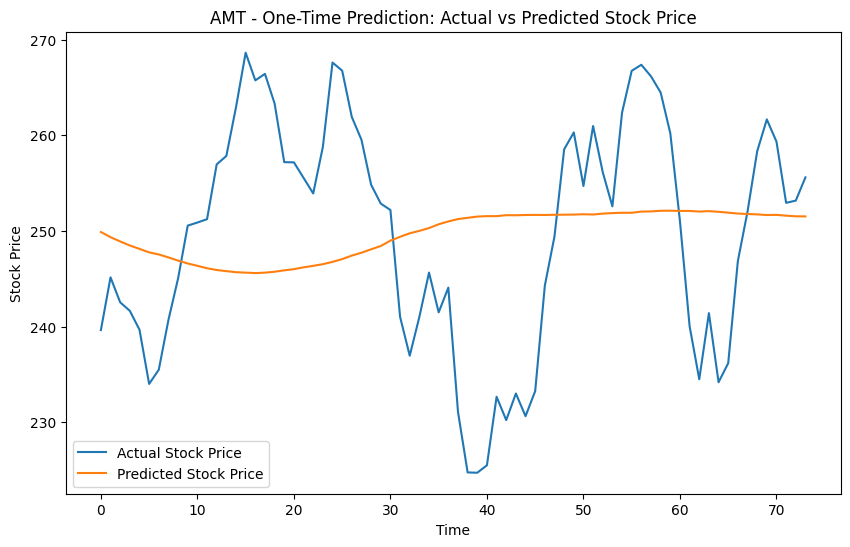

Ticker: XOM
Mean Squared Error (MSE): 213.47265533491597
Root Mean Squared Error (RMSE): 14.6107034510634
Mean Absolute Percentage Error (MAPE): 15.12426183820042%


Ticker: SHW
Mean Squared Error (MSE): 737.985744619682
Root Mean Squared Error (RMSE): 27.16589303924467
Mean Absolute Percentage Error (MAPE): 8.808748145999926%


Ticker: AMZN
Mean Squared Error (MSE): 739.8286569050649
Root Mean Squared Error (RMSE): 27.199791486426232
Mean Absolute Percentage Error (MAPE): 19.65794830503859%


Ticker: PG
Mean Squared Error (MSE): 64.79563348999915
Root Mean Squared Error (RMSE): 8.049573497397185
Mean Absolute Percentage Error (MAPE): 4.458812356836532%


Ticker: JNJ
Mean Squared Error (MSE): 74.7413903490968
Root Mean Squared Error (RMSE): 8.645310309589634
Mean Absolute Percentage Error (MAPE): 4.3838139010484545%


Ticker: JPM
Mean Squared Error (MSE): 466.71997038871507
Root Mean Squared Error (RMSE): 21.603702700896324
Mean Absolute Percentage Error (MAPE): 16.80445631822567%


Ti

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# List of tickers
tickers = ["XOM", "SHW", "AMZN", "PG", "JNJ", "JPM", "AAPL", "GOOGL", "NEE", "AMT"]

# Load and preprocess the dataset
data = pd.read_csv("C:/Users/tanxi/Downloads/company_stock_details.csv", low_memory=False)

# Initialize results dictionary to store results for each company
results = {}

# Define the Attention LSTM model
class AttentionLSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size=1, num_layers=1):
        super(AttentionLSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True, bidirectional=True)
        self.attention = nn.Linear(hidden_layer_size * 2, 1)
        self.linear = nn.Linear(hidden_layer_size * 2, output_size)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_layer_size).requires_grad_()
        c_0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_layer_size).requires_grad_()

        lstm_out, _ = self.lstm(x, (h_0, c_0))  # LSTM output
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)  # Compute attention weights
        context = torch.sum(attn_weights * lstm_out, dim=1)  # Weighted sum
        predictions = self.linear(context)
        return predictions

# Define function to create sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # Predicting the 'Close_Log' (log-transformed close price)
    return np.array(X), np.array(y)

# Hyperparameters
sequence_length = 45
hidden_layer_size = 384
num_layers = 1
dropout_rate = 0.2
learning_rate = 0.00005
batch_size = 16
epochs = 150
early_stopping_patience = 10

# Loop through each ticker and train an individual model
for ticker in tickers:
    print(f"\nProcessing ticker: {ticker}")
    
    # Filter data for specific ticker
    data_filtered = data[data['Symbol'] == ticker]

    # Feature engineering
    data_filtered['Close_Log'] = np.log1p(data_filtered['Close'])
    data_filtered['Close_MA7'] = data_filtered['Close'].rolling(window=7).mean()
    data_filtered['Close_MA30'] = data_filtered['Close'].rolling(window=30).mean()
    data_filtered = data_filtered[['Close_Log', 'Volume', 'News - Positive Sentiment', 'News - Negative Sentiment', 
                                   'News - New Products', 'News - Analyst Comments', 'News - Adverse Events', 
                                   'Close_MA7', 'Close_MA30']].dropna()

    # Scale data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data_filtered)

    # Create sequences
    X, y = create_sequences(scaled_data, sequence_length)

    # Split into train and validation sets
    split_index = int(len(X) * 0.8)
    X_train, X_val = X[:split_index], X[split_index:]
    y_train, y_val = y[:split_index], y[split_index:]

    # Convert to tensors
    X_train_tensor = torch.from_numpy(X_train).float()
    y_train_tensor = torch.from_numpy(y_train).float()

    # Initialize the model, loss function, and optimizer
    input_size = data_filtered.shape[1]
    model = AttentionLSTM(input_size=input_size, hidden_layer_size=hidden_layer_size)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    # Early stopping setup
    min_val_loss = np.inf
    early_stop_counter = 0

    # Training loop
    for epoch in range(epochs):
        model.train()
        for i in range(0, len(X_train_tensor), batch_size):
            X_batch = X_train_tensor[i:i+batch_size]
            y_batch = y_train_tensor[i:i+batch_size]
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_function(y_pred, y_batch.unsqueeze(1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            X_val_tensor = torch.from_numpy(X_val).float()
            y_val_tensor = torch.from_numpy(y_val).float()
            y_pred_val = model(X_val_tensor)
            val_loss = loss_function(y_pred_val, y_val_tensor.unsqueeze(1)).item()
        
        print(f"Epoch {epoch+1}/{epochs} - {ticker} - Training Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}")
        
        # Scheduler step
        scheduler.step(val_loss)

        # Early stopping check
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= early_stopping_patience:
                print(f"Early stopping triggered for {ticker}")
                break

    # One-time prediction on the validation set
    model.eval()
    with torch.no_grad():
        X_val_tensor = torch.from_numpy(X_val).float()
        y_pred_val = model(X_val_tensor).squeeze().numpy()

    # Rescale and evaluate
    actual_values_rescaled = np.expm1(scaler.inverse_transform(
        np.concatenate([y_val.reshape(-1, 1), np.zeros((len(y_val), input_size - 1))], axis=1))[:, 0])
    predicted_values_rescaled = np.expm1(scaler.inverse_transform(
        np.concatenate([y_pred_val.reshape(-1, 1), np.zeros((len(y_pred_val), input_size - 1))], axis=1))[:, 0])

    # Calculate error metrics
    mse = mean_squared_error(actual_values_rescaled, predicted_values_rescaled)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual_values_rescaled - predicted_values_rescaled) / actual_values_rescaled)) * 100

    # Store results for the ticker
    results[ticker] = {
        "MSE": mse,
        "RMSE": rmse,
        "MAPE": mape,
        "Actual": actual_values_rescaled,
        "Predicted": predicted_values_rescaled
    }

    # Plot for each company
    plt.figure(figsize=(10, 6))
    plt.plot(actual_values_rescaled, label='Actual Stock Price')
    plt.plot(predicted_values_rescaled, label='Predicted Stock Price')
    plt.title(f'{ticker} - One-Time Prediction: Actual vs Predicted Stock Price')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

# Print summary of results for each company
for ticker, metrics in results.items():
    print(f"Ticker: {ticker}")
    print(f"Mean Squared Error (MSE): {metrics['MSE']}")
    print(f"Root Mean Squared Error (RMSE): {metrics['RMSE']}")
    print(f"Mean Absolute Percentage Error (MAPE): {metrics['MAPE']}%")
    print("\n")


Sources referred to for codes:

Hochreiter, S., & Schmidhuber, J. (1997). Long short-term memory. Neural computation, 9(8), 1735-1780.

This paper is the original introduction to Long Short-Term Memory (LSTM) networks, describing the architecture and benefits of using LSTM for handling long-term dependencies in sequential data.
Graves, A., Mohamed, A. R., & Hinton, G. (2013). Speech recognition with deep recurrent neural networks. In 2013 IEEE International Conference on Acoustics, Speech and Signal Processing (pp. 6645-6649). IEEE.

This work demonstrates LSTM applications in deep neural networks, particularly for sequential data like speech, and provides insights into tuning LSTM for complex time series tasks.
Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). Attention is all you need. Advances in neural information processing systems, 30.

This foundational paper introduces the concept of attention mechanisms, which are now commonly incorporated into LSTM-based models to improve focus on relevant parts of sequences.
Brownlee, J. (2018). Deep Learning for Time Series Forecasting: Predict the Future with MLPs, CNNs and LSTMs in Python. Machine Learning Mastery.

Brownlee provides practical implementations of LSTM models for time series forecasting, including methods for creating input sequences and tuning LSTM parameters. Available at Machine Learning Mastery.
Chollet, F. (2015). Keras. GitHub repository. https://github.com/fchollet/keras

Keras documentation and example codes are essential resources for building LSTM models in Python. The Keras repository includes examples of LSTM architectures for various applications.
Graves, A. (2012). Supervised sequence labelling with recurrent neural networks. In Studies in Computational Intelligence, Vol. 385. Springer, Berlin, Heidelberg.

This book covers practical applications of LSTM and other recurrent neural networks, including code and explanations on sequence modeling and handling time series data.
Pytorch Team. (2019). PyTorch Documentation. https://pytorch.org/docs/stable/index.html

The official PyTorch documentation provides extensive examples and best practices for implementing LSTM models, including tutorials on sequence modeling and time series forecasting with LSTM and attention layers.